<a href="https://colab.research.google.com/github/NealWhitlock/Predictive-Project-1/blob/master/Fitbit_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install plotly
!pip install eli5

In [0]:
import pandas as pd
import numpy as np

import matplotlib as plt
import plotly.express as px
%matplotlib inline

# Get the dataset

In [0]:
fitbit_url = 'https://raw.githubusercontent.com/NealWhitlock/Predictive-Project-1/master/fitbit-2018-2019.csv'

In [0]:
df = pd.read_csv(fitbit_url, index_col='Date', parse_dates=True)

df.head().T

Date,2018-04-01 00:00:00,2018-04-02 00:00:00,2018-04-03 00:00:00,2018-04-04 00:00:00,2018-04-05 00:00:00
Calories Burned,"2,744","3,761","3,328","2,926","3,249"
Steps,"4,239","10,129","8,009","5,821","7,763"
Distance,1.97,4.63,3.72,2.7,3.6
Floors,0,11,0,0,0
Minutes Sedentary,628,632,700,651,608
Minutes Lightly Active,241,333,287,243,308
Minutes Fairly Active,0,32,5,1,7
Minutes Very Active,0,24,8,9,0
Activity Calories,"1,007","2,097","1,528","1,133","1,550"
RHR Day 1,58,57,58,59,59


## Some numerical columns are treated as strings because of commas

In [0]:
# Remove the commas
df['Calories Burned'] = df['Calories Burned'].str.replace(',','')
df['Steps'] = df['Steps'].str.replace(',','')
df['Minutes Sedentary'] = df['Minutes Sedentary'].str.replace(',','')
df['Activity Calories'] = df['Activity Calories'].str.replace(',','')

In [0]:
# Change strings to floats (can't do int because of missing values)
df['Calories Burned'] = df['Calories Burned'].astype(float)
df['Steps'] = df['Steps'].astype(float)
df['Minutes Sedentary'] = df['Minutes Sedentary'].astype(float)
df['Activity Calories'] = df['Activity Calories'].astype(float)

## Make new columns to represent the activity levels for subsequent days

In [0]:
# The commented code is for extending the predictions out to one week rather than 4 days
df['Activity Calories Day 2'] = df['Activity Calories'].shift(-1)
df['Activity Calories Day 3'] = df['Activity Calories'].shift(-2)
df['Activity Calories Day 4'] = df['Activity Calories'].shift(-3)
# df['Activity Calories 4 Day'] = df['Activity Calories'].shift(-4)
# df['Activity Calories 5 Day'] = df['Activity Calories'].shift(-5)
# df['Activity Calories 6 Day'] = df['Activity Calories'].shift(-6)

df['Minutes Very Active Day 2'] = df['Minutes Very Active'].shift(-1)
df['Minutes Very Active Day 3'] = df['Minutes Very Active'].shift(-2)
df['Minutes Very Active Day 4'] = df['Minutes Very Active'].shift(-3)

df['Steps Day 2'] = df['Steps'].shift(-1)
df['Steps Day 3'] = df['Steps'].shift(-2)
df['Steps Day 4'] = df['Steps'].shift(-3)
# df['Steps 4 Day'] = df['Steps'].shift(-4)
# df['Steps 5 Day'] = df['Steps'].shift(-5)
# df['Steps 6 Day'] = df['Steps'].shift(-6)

df['Minutes Asleep Day 2'] = df['Minutes Asleep'].shift(-1)
df['Minutes Asleep Day 3'] = df['Minutes Asleep'].shift(-2)
df['Minutes Asleep Day 4'] = df['Minutes Asleep'].shift(-3)
# df['Minutes Asleep 4 Day'] = df['Minutes Asleep'].shift(-4)
# df['Minutes Asleep 5 Day'] = df['Minutes Asleep'].shift(-5)
# df['Minutes Asleep 6 Day'] = df['Minutes Asleep'].shift(-6)

# df['RHR 5 Day'] = df['RHR 4 Day'].shift(-1)
# df['RHR 6 Day'] = df['RHR 5 Day'].shift(-1)
# df['RHR 7 Day'] = df['RHR 6 Day'].shift(-1)

## Interpolate the missing values rather than dropping

In [0]:
for col in df.columns:
    df[col] = df[col].interpolate()

# Baseline Errors

In [0]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [0]:
baseline = [df['RHR Day 5'].mean()] * len(df['RHR Day 5'])

print(f"Mean Absolute Error of Baseline: {mean_absolute_error(df['RHR Day 5'], baseline):.2f} BPM")
print(f"Root Mean Squared Error of Baseline: {(mean_squared_error(df['RHR Day 5'], baseline))**0.5:.2f} BPM")
print(f"R^2 Score: {r2_score(df['RHR Day 5'], baseline)}")

Mean Absolute Error of Baseline: 2.32 BPM
Root Mean Squared Error of Baseline: 2.78 BPM
R^2 Score: 0.0


# Visualizations

In [0]:
fig1 = px.scatter(df, x='RHR Day 1', y='Activity Calories', color='RHR Day 2', opacity=0.5)
fig1.update_layout(
    title = {
        'text': "Day 1 RHR and Activity Calories impact on Day 2 RHR",
        'x': 0.47,
        'y': 0.93
    },
    font = dict(
        size=17
    ))
fig1.update_traces(marker=dict(size=12),
                  selector=dict(mode='markers'))
fig1

In [0]:
fig2 = px.scatter(df, x='RHR Day 1', y='Activity Calories', color='RHR Day 5', opacity=0.5)
fig2.update_layout(
    title = {
        'text': "Day 1 RHR and Activity Calories impact on Day 5 RHR",
        'x': 0.47,
        'y': 0.93
    },
    font = dict(
        size=17
    ))
fig2.update_traces(marker=dict(size=12),
                  selector=dict(mode='markers'))
fig2

In [0]:
fig3 = px.scatter(df, x='RHR Day 4', y='Activity Calories Day 4', marginal_x='histogram', 
           color='RHR Day 5', opacity=0.5)
fig3.update_layout(
    title = {
        'text': "Day 4 RHR and Activity Calories impact on Day 5 RHR",
        'x': 0.47,
        'y': 0.93
    },
    font = dict(
        size=17
    ))
fig3.update_traces(marker=dict(size=12),
                  selector=dict(mode='markers'))
fig3

In [0]:
fig4 = px.scatter(df, x='Activity Calories', y='Minutes Very Active', color='RHR Day 2', opacity=0.75)
fig4.update_layout(
    title = {
        'text': "Day 1 Activity Calories and Minutes Very Active",
        'x': 0.47,
        'y': 0.93
    },
    font = dict(
        size=17
    ))
fig4.update_traces(marker=dict(size=12),
                  selector=dict(mode='markers'))
fig4

In [0]:
fig5 = px.scatter(df, x='RHR Day 1', y='RHR Day 2', color='RHR Day 3', trendline='ols', opacity=0.8)
fig5.update_layout(
    title = {
        'text': "Days 1 and 2 RHR",
        'x': 0.47,
        'y': 0.93
    },
    font = dict(
        size=17
    ))
fig5.update_traces(marker=dict(size=12),
                  selector=dict(mode='markers'))
fig5

## New Features Function - Ultimately Not Used

In [0]:
def new_features(X):
    X = X.copy()

  # Fill all NaNs with 1 to not mess up some of the following calculations
#    X.fillna(1)

  # New features regarding minutes spent active
    X['Minutes Lightly Active 1 Day'] = X['Minutes Lightly Active'].shift(-1)
    X['Minutes Lightly Active 2 Day'] = X['Minutes Lightly Active'].shift(-2)
    X['Minutes Lightly Active 3 Day'] = X['Minutes Lightly Active'].shift(-3)
    
    X['Minutes Fairly Active 1 Day'] = X['Minutes Fairly Active'].shift(-1)
    X['Minutes Fairly Active 2 Day'] = X['Minutes Fairly Active'].shift(-2)
    X['Minutes Fairly Active 3 Day'] = X['Minutes Fairly Active'].shift(-3)
    
    X['Minutes Very Active 1 Day'] = X['Minutes Very Active'].shift(-1)
    X['Minutes Very Active 2 Day'] = X['Minutes Very Active'].shift(-2)
    X['Minutes Very Active 3 Day'] = X['Minutes Very Active'].shift(-3)
    
    X['Minutes Sedentary 1 Day'] = X['Minutes Sedentary'].shift(-1)
    X['Minutes Sedentary 2 Day'] = X['Minutes Sedentary'].shift(-2)
    X['Minutes Sedentary 3 Day'] = X['Minutes Sedentary'].shift(-3)
    
    X['Active Minutes'] = (X['Minutes Lightly Active'] + X['Minutes Fairly Active'] + X['Minutes Very Active'])
    X['Active Minutes 1 Day'] = (X['Minutes Lightly Active'] + X['Minutes Fairly Active'] + X['Minutes Very Active']).shift(-1)
    X['Active Minutes 2 Day'] = (X['Minutes Lightly Active'] + X['Minutes Fairly Active'] + X['Minutes Very Active']).shift(-2)
    X['Active Minutes 3 Day'] = (X['Minutes Lightly Active'] + X['Minutes Fairly Active'] + X['Minutes Very Active']).shift(-3)
    
    X['Percent Light Active'] = (X['Minutes Lightly Active'] / X['Active Minutes'])
    X['Percent Light Active 1 Day'] = (X['Minutes Lightly Active'] / X['Active Minutes']).shift(-1)
    X['Percent Light Active 2 Day'] = (X['Minutes Lightly Active'] / X['Active Minutes']).shift(-2)
    X['Percent Light Active 3 Day'] = (X['Minutes Lightly Active'] / X['Active Minutes']).shift(-3)
    
    X['Percent Fairly Active'] = (X['Minutes Fairly Active'] / X['Active Minutes'])
    X['Percent Fairly Active 1 Day'] = (X['Minutes Fairly Active'] / X['Active Minutes']).shift(-1)
    X['Percent Fairly Active 2 Day'] = (X['Minutes Fairly Active'] / X['Active Minutes']).shift(-2)
    X['Percent Fairly Active 3 Day'] = (X['Minutes Fairly Active'] / X['Active Minutes']).shift(-3)
    
    X['Percent Very Active'] = (X['Minutes Very Active'] / X['Active Minutes'])
    X['Percent Very Active 1 Day'] = (X['Minutes Very Active'] / X['Active Minutes']).shift(-1)
    X['Percent Very Active 2 Day'] = (X['Minutes Very Active'] / X['Active Minutes']).shift(-2)
    X['Percent Very Active 3 Day'] = (X['Minutes Very Active'] / X['Active Minutes']).shift(-3)
    
    X['Minutes Tracked'] = (X['Active Minutes'] + X['Minutes Sedentary'])
    X['Minutes Tracked 1 Day'] = (X['Active Minutes'] + X['Minutes Sedentary']).shift(-1)
    X['Minutes Tracked 2 Day'] = (X['Active Minutes'] + X['Minutes Sedentary']).shift(-2)
    X['Minutes Tracked 3 Day'] = (X['Active Minutes'] + X['Minutes Sedentary']).shift(-3)
    
    X['Percent Sitting'] = (X['Minutes Sedentary'] / X['Minutes Tracked'])
    X['Percent Sitting 1 Day'] = (X['Minutes Sedentary'] / X['Minutes Tracked']).shift(-1)
    X['Percent Sitting 2 Day'] = (X['Minutes Sedentary'] / X['Minutes Tracked']).shift(-2)
    X['Percent Sitting 3 Day'] = (X['Minutes Sedentary'] / X['Minutes Tracked']).shift(-3)
    
    X['Percent Moving'] = (X['Active Minutes'] / X['Minutes Tracked'])
    X['Percent Moving 1 Day'] = (X['Active Minutes'] / X['Minutes Tracked']).shift(-1)
    X['Percent Moving 2 Day'] = (X['Active Minutes'] / X['Minutes Tracked']).shift(-2)
    X['Percent Moving 3 Day'] = (X['Active Minutes'] / X['Minutes Tracked']).shift(-3)

  # Inverse activity features
#     X['Inverse Active Minutes'] = 1 / X['Active Minutes']
#     X['Inverse Steps'] = 1 / X['Steps']
#     X['Inverse Steps 5000'] = 1 / (X['Steps']-5000)
#     X['Inverse Steps 5000 Multiple 2'] = 2 / (X['Steps']-5000)
#     X['Inverse Steps 5000 Multiple 3'] = 3 / (X['Steps']-5000)
#     X['Inverse Steps 10000'] = 1 / (X['Steps']-10000)
#     X['Inverse Steps 15000'] = 1 / (X['Steps']-15000)
#     X['Inverse Steps Multiple 2'] = 2 / X['Steps']
#     X['Inverse Steps Multiple 3'] = 3 / X['Steps']
#     X['Inverse Steps Multiple 4'] = 4 / X['Steps']
#     X['Inverse Steps Multiple 5'] = 5 / X['Steps']
#     X['Inverse Activity Calories'] = 1 / X['Activity Calories']
#     X['Inverse Activity Calories 500'] = 1 / (X['Activity Calories']-500)
#     X['Inverse Activity Calories 1000'] = 1 / (X['Activity Calories']-1000)
#     X['Inverse Activity Calories 1500'] = 1 / (X['Activity Calories']-1500)
#     X['Inverse Activity Calories 2000'] = 1 / (X['Activity Calories']-2000)
#     X['Inverse Activity Calories 2000 Multiple 2'] = 2 / (X['Activity Calories']-2000)
#     X['Inverse Activity Calories 2000 Multiple 3'] = 3 / (X['Activity Calories']-2000)
#     X['Inverse Activity Calories 2000 Multiple 4'] = 4 / (X['Activity Calories']-2000)
#     X['Inverse Activity Calories Multiple 2'] = 2 / X['Activity Calories']
#     X['Inverse Activity Calories Multiple 3'] = 3 / X['Activity Calories']
#     X['Inverse Activity Calories Multiple 4'] = 4 / X['Activity Calories']
#     X['Inverse Activity Calories Multiple 5'] = 5 / X['Activity Calories']
#     X['Inverse Distance'] = 1 / X['Distance']
#     X['Inverse Very Active Minutes'] = 1 / X['Minutes Very Active']
#     X['Inverse Fairly Active Minutes'] = 1 / X['Minutes Fairly Active']
#     X['Inverse Lightly Active Minutes'] = 1 / X['Minutes Lightly Active']
#     X['Inverse Calories Burned'] = 1 / X['Calories Burned']
#     X['Inverse Percent Moving'] = 1 / X['Percent Moving']

  # Negative Values
#     X['Negative Steps'] = X['Steps'] * -1
#     X['Negative Activity Calories'] = X['Activity Calories'] * -1
  
  # Calorie burn rate for active time
    X['Calorie Burn'] = (X['Activity Calories'] / X['Active Minutes'])
    X['Calorie Burn 1 Day'] = (X['Activity Calories'] / X['Active Minutes']).shift(-1)
    X['Calorie Burn 2 Day'] = (X['Activity Calories'] / X['Active Minutes']).shift(-2)
    X['Calorie Burn 3 Day'] = (X['Activity Calories'] / X['Active Minutes']).shift(-3)

  # Sleep time
    X['Percent Asleep'] = (X['Minutes Asleep'] / X['Time in Bed'])
    X['Percent Asleep 1 Day'] = (X['Minutes Asleep'] / X['Time in Bed']).shift(-1)
    X['Percent Asleep 2 Day'] = (X['Minutes Asleep'] / X['Time in Bed']).shift(-2)
    X['Percent Asleep 3 Day'] = (X['Minutes Asleep'] / X['Time in Bed']).shift(-3)
    
    X['Percent REM Sleep'] = (X['Minutes REM Sleep'] / X['Minutes Asleep'])
    X['Percent REM Sleep 1 Day'] = (X['Minutes REM Sleep'] / X['Minutes Asleep']).shift(-1)
    X['Percent REM Sleep 2 Day'] = (X['Minutes REM Sleep'] / X['Minutes Asleep']).shift(-2)
    X['Percent REM Sleep 3 Day'] = (X['Minutes REM Sleep'] / X['Minutes Asleep']).shift(-3)
    
    X['Percent Light Sleep'] = (X['Minutes Light Sleep'] / X['Minutes Asleep'])
    X['Percent Light Sleep 1 Day'] = (X['Minutes Light Sleep'] / X['Minutes Asleep']).shift(-1)
    X['Percent Light Sleep 2 Day'] = (X['Minutes Light Sleep'] / X['Minutes Asleep']).shift(-2)
    X['Percent Light Sleep 3 Day'] = (X['Minutes Light Sleep'] / X['Minutes Asleep']).shift(-3)
    
    X['Percent Deep Sleep'] = (X['Minutes Deep Sleep'] / X['Minutes Asleep'])
    X['Percent Deep Sleep 1 Day'] = (X['Minutes Deep Sleep'] / X['Minutes Asleep']).shift(-1)
    X['Percent Deep Sleep 2 Day'] = (X['Minutes Deep Sleep'] / X['Minutes Asleep']).shift(-2)
    X['Percent Deep Sleep 3 Day'] = (X['Minutes Deep Sleep'] / X['Minutes Asleep']).shift(-3)
    
    X['Ave Time Asleep'] = (X['Minutes Asleep'] / X['Number of Awakenings'])
    X['Ave Time Asleep 1 Day'] = (X['Minutes Asleep'] / X['Number of Awakenings']).shift(-1)
    X['Ave Time Asleep 2 Day'] = (X['Minutes Asleep'] / X['Number of Awakenings']).shift(-2)
    X['Ave Time Asleep 3 Day'] = (X['Minutes Asleep'] / X['Number of Awakenings']).shift(-3)
    
    X['Hours Asleep'] = (X['Minutes Asleep'] // 60)
    X['Hours Asleep 1 Day'] = (X['Minutes Asleep'] // 60).shift(-1)
    X['Hours Asleep 2 Day'] = (X['Minutes Asleep'] // 60).shift(-2)
    X['Hours Asleep 3 Day'] = (X['Minutes Asleep'] // 60).shift(-3)
    
    X['Minutes Asleep 1 Day'] = X['Minutes Asleep'].shift(-1)
    X['Minutes Asleep 2 Day'] = X['Minutes Asleep'].shift(-2)
    X['Minutes Asleep 3 Day'] = X['Minutes Asleep'].shift(-3)
    
    X['Minutes Awake 1 Day'] = X['Minutes Awake'].shift(-1)
    X['Minutes Awake 2 Day'] = X['Minutes Awake'].shift(-2)
    X['Minutes Awake 3 Day'] = X['Minutes Awake'].shift(-3)
    
    X['Number of Awakenings 1 Day'] = X['Number of Awakenings'].shift(-1)
    X['Number of Awakenings 2 Day'] = X['Number of Awakenings'].shift(-2)
    X['Number of Awakenings 3 Day'] = X['Number of Awakenings'].shift(-3)
    
    X['Time in Bed 1 Day'] = X['Time in Bed'].shift(-1)
    X['Time in Bed 2 Day'] = X['Time in Bed'].shift(-2)
    X['Time in Bed 3 Day'] = X['Time in Bed'].shift(-3)
    
    X['Minutes REM Sleep 1 Day'] = X['Minutes REM Sleep'].shift(-1)
    X['Minutes REM Sleep 2 Day'] = X['Minutes REM Sleep'].shift(-2)
    X['Minutes REM Sleep 3 Day'] = X['Minutes REM Sleep'].shift(-3)
    
    X['Minutes Light Sleep 1 Day'] = X['Minutes Light Sleep'].shift(-1)
    X['Minutes Light Sleep 2 Day'] = X['Minutes Light Sleep'].shift(-2)
    X['Minutes Light Sleep 3 Day'] = X['Minutes Light Sleep'].shift(-3)
    
    X['Minutes Deep Sleep 1 Day'] = X['Minutes Deep Sleep'].shift(-1)
    X['Minutes Deep Sleep 2 Day'] = X['Minutes Deep Sleep'].shift(-2)
    X['Minutes Deep Sleep 3 Day'] = X['Minutes Deep Sleep'].shift(-3)
    
    
#    X['Get in Bed Hour'] = pd.to_datetime(X['Start Time']).dt.hour
#    X['Get out of Bed Hour'] = pd.to_datetime(X['End Time']).dt.hour
#    X['Wasted Time'] = X['Minutes Awake'] / X['Time in Bed']

    X['Activity Calories 1 Day'] = X['Activity Calories'].shift(-1)
    X['Activity Calories 2 Day'] = X['Activity Calories'].shift(-2)
    X['Activity Calories 3 Day'] = X['Activity Calories'].shift(-3)

    X['Steps 1 Day'] = X['Steps'].shift(-1)
    X['Steps 2 Day'] = X['Steps'].shift(-2)
    X['Steps 3 Day'] = X['Steps'].shift(-3)

    X['Minutes Asleep 1 Day'] = X['Minutes Asleep'].shift(-1)
    X['Minutes Asleep 2 Day'] = X['Minutes Asleep'].shift(-2)
    X['Minutes Asleep 3 Day'] = X['Minutes Asleep'].shift(-3)


  # Stride length?
    X['Step Stride'] = ((X['Distance'] / X['Steps']) * 5280)
    X['Step Stride 1 Day'] = ((X['Distance'] / X['Steps']) * 5280).shift(-1)
    X['Step Stride 2 Day'] = ((X['Distance'] / X['Steps']) * 5280).shift(-2)
    X['Step Stride 3 Day'] = ((X['Distance'] / X['Steps']) * 5280).shift(-3)

  # Month
#    X['Month'] = pd.to_datetime(X['Date']).dt.month

  # Drop columns
#    X = X.drop(columns=['Date','RHR Change','Start Time','End Time'])

#    one_cols = ['Floors', 'Get in Bed Hour', 'Month']

  # Replace NaNs in dataframe
#    X = X.replace(1, np.nan)

  # Put ones back where they were supposed to be
#    for col in one_cols:
#        X.fillna(1)

  # Catch any stragglers
    X[X==np.inf]=np.nan

    return X

# Split data into training and testing groups

In [0]:
cutoff = '2019-10-1'

In [0]:
training = df[df.index < cutoff] # 18 months for training
testing = df[df.index >= cutoff] # 4 months for testing

training.shape, testing.shape

((548, 36), (123, 36))

In [0]:
# New Features function not used

# train = new_features(training)
# test = new_features(testing)

# train.shape, test.shape

((548, 123), (123, 123))

In [0]:
len(training.columns)

36

In [0]:
target = 'RHR Day 5'
drop_cols = [target, 'RHR Change', 'Start Time', 'End Time', 'Calories Burned']

X_train = training.drop(columns=drop_cols)
y_train = training[target]
X_test = testing.drop(columns=drop_cols)
y_test = testing[target]

In [0]:
len(X_test.columns)

31

## Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
model = LinearRegression()

In [0]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [0]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Mean MAE for 5 folds", -scores.mean())

Mean MAE for 5 folds 0.7985237669399041


In [0]:
y_pred = model.predict(X_test)

In [0]:
print(f"Mean Absolute Error on Test: {mean_absolute_error(y_test, y_pred):.2f} BPM")
print(f"Root Mean Squared Error on Test: {(mean_squared_error(y_test, y_pred))**0.5:.2f} BPM")
print(f"R^2 Score: {r2_score(y_test, y_pred)}")

Mean Absolute Error on Test: 0.68 BPM
Root Mean Squared Error on Test: 0.84 BPM
R^2 Score: 0.7465943682124101


In [0]:
lr_mae_change = (mean_absolute_error(y_test, y_pred) / mean_absolute_error(df['RHR Day 5'], baseline) - 1) * 100
lr_rmse_change = ((mean_squared_error(y_test, y_pred))**0.5 / (mean_squared_error(df['RHR Day 5'], baseline))**0.5 - 1) * 100
lr_r2_change = r2_score(y_test, y_pred) - r2_score(df['RHR Day 5'], baseline)

In [0]:
print("Using Linear Regression resulted in the following improvements over the baseline:")
print(f"MAE had a {lr_mae_change:.2f}% change.")
print(f"RMSE changed by {lr_rmse_change:.2f}%.")
print(f"The R^2 score went up {lr_r2_change:.2f}.")

Using Linear Regression resulted in the following improvements over the baseline:
MAE had a -70.71% change.
RMSE changed by -69.78%.
The R^2 score went up 0.75.


### Intercept and Coefficients for Linear Regression

In [0]:
print('Intercept:', model.intercept_)
print('-----------------------------')
print('  Coeff. : Feature')
for i in range(len(model.coef_)):
    if model.coef_[i] < 0:
        print(f"{model.coef_[i]:.6f}: {X_train.columns[i]}")
    else:
        print(f" {model.coef_[i]:.6f}: {X_train.columns[i]}")

Intercept: 7.635181684411215
-----------------------------
  Coeff. : Feature
-0.000001: Steps
 0.148246: Distance
-0.005320: Floors
-0.000456: Minutes Sedentary
-0.001640: Minutes Lightly Active
 0.001840: Minutes Fairly Active
-0.007628: Minutes Very Active
-0.000317: Activity Calories
 0.029482: RHR Day 1
-0.046148: RHR Day 2
-0.033856: RHR Day 3
 0.939923: RHR Day 4
-0.014877: Minutes Asleep
-0.012696: Minutes Awake
 0.000460: Number of Awakenings
 0.011945: Time in Bed
-0.000530: Minutes REM Sleep
 0.000695: Minutes Light Sleep
 0.001676: Minutes Deep Sleep
 0.000180: Activity Calories Day 2
 0.000086: Activity Calories Day 3
 0.000616: Activity Calories Day 4
-0.006053: Minutes Very Active Day 2
 0.000046: Minutes Very Active Day 3
 0.000612: Minutes Very Active Day 4
 0.000003: Steps Day 2
-0.000006: Steps Day 3
-0.000044: Steps Day 4
 0.001076: Minutes Asleep Day 2
-0.000228: Minutes Asleep Day 3
-0.001154: Minutes Asleep Day 4


## Random Forest

In [0]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

In [0]:
pipeline = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy='median'),
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("Mean MAE for 5 folds", -scores.mean())

Mean MAE for 5 folds 0.8654232336470867


In [0]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,...timators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [0]:
pipeline.fit(X_train, y_train)
y_rf_pred = pipeline.predict(X_test)

In [0]:
print(f"Mean Absolute Error on Test: {mean_absolute_error(y_test, y_rf_pred):.2f} BPM")
print(f"Root Mean Squared Error on Test: {(mean_squared_error(y_test, y_rf_pred))**0.5:.2f} BPM")
print(f"R^2 Score: {r2_score(y_test, y_rf_pred)}")

Mean Absolute Error on Test: 0.71 BPM
Root Mean Squared Error on Test: 0.92 BPM
R^2 Score: 0.6966359785599088


In [0]:
rf_mae_change = (mean_absolute_error(y_test, y_rf_pred) / mean_absolute_error(df['RHR Day 5'], baseline) - 1) * 100
rf_rmse_change = ((mean_squared_error(y_test, y_rf_pred))**0.5 / (mean_squared_error(df['RHR Day 5'], baseline))**0.5 - 1) * 100
rf_r2_change = r2_score(y_test, y_rf_pred) - r2_score(df['RHR Day 5'], baseline)

In [0]:
print("Using Random Forest resulted in the following improvements over the baseline:")
print(f"MAE had a {rf_mae_change:.2f}% change.")
print(f"RMSE changed by {rf_rmse_change:.2f}%.")
print(f"The R^2 score went up {rf_r2_change:.2f}.")

Using Random Forest resulted in the following improvements over the baseline:
MAE had a -69.29% change.
RMSE changed by -66.93%.
The R^2 score went up 0.70.


### Feature Importances for Random Forest

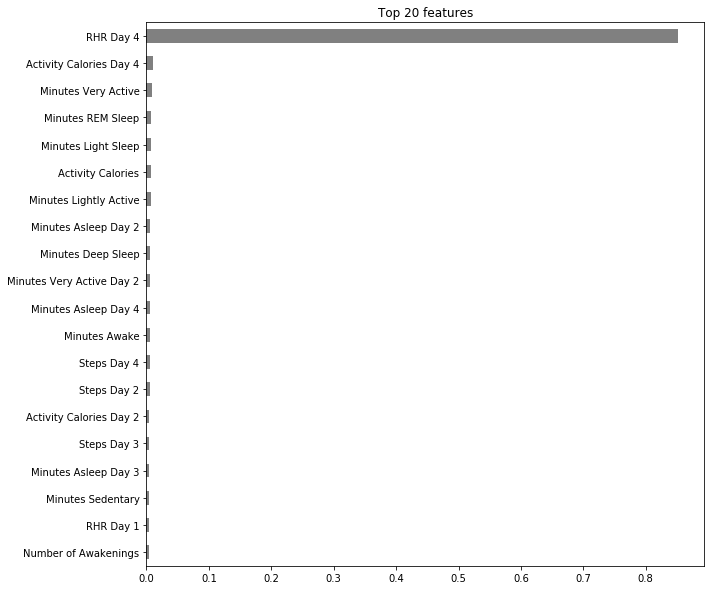

In [0]:
# Get feature importances
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [0]:
importances.sort_values(ascending=False)

RHR Day 4                    0.851507
Activity Calories Day 4      0.009797
Minutes Very Active          0.008709
Minutes REM Sleep            0.007003
Minutes Light Sleep          0.006895
Activity Calories            0.006714
Minutes Lightly Active       0.006562
Minutes Asleep Day 2         0.006472
Minutes Deep Sleep           0.006334
Minutes Very Active Day 2    0.005887
Minutes Asleep Day 4         0.005527
Minutes Awake                0.005469
Steps Day 4                  0.004992
Steps Day 2                  0.004924
Activity Calories Day 2      0.004800
Steps Day 3                  0.004773
Minutes Asleep Day 3         0.004643
Minutes Sedentary            0.004542
RHR Day 1                    0.004504
Number of Awakenings         0.004433
Minutes Very Active Day 4    0.004354
Activity Calories Day 3      0.003563
Minutes Very Active Day 3    0.003512
Minutes Asleep               0.003462
Floors                       0.003382
Distance                     0.003289
Minutes Fair

### Random Forest Hyperparameters

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [0]:
param_distributions={
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestregressor__n_estimators': randint(50,500),
    'randomforestregressor__max_depth': [5, 10, 15, 20, None],
    'randomforestregressor__max_features': uniform(0,1),
    'randomforestregressor__min_samples_leaf': [5, 10, 15]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=200,
    cv=15,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 15 folds for each of 200 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

In [0]:
print('Best hyperparameters', search.best_params_)
print('Best MAE', -search.best_score_)
model_best = search.best_estimator_

Best hyperparameters {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 0.8542391023207399, 'randomforestregressor__min_samples_leaf': 5, 'randomforestregressor__n_estimators': 438, 'simpleimputer__strategy': 'mean'}
Best MAE 0.8489518012725978


In [0]:
y_best_rf_pred = model_best.predict(X_test)

In [0]:
print(f"Mean Absolute Error on Test with RF Best Fit: {mean_absolute_error(y_test, y_best_rf_pred):.2f} BPM")
print(f"Root Mean Squared Error on Test with RF Best Fit: {(mean_squared_error(y_test, y_best_rf_pred))**0.5:.2f} BPM")
print(f"R^2 Score: {r2_score(y_test, y_best_rf_pred)}")

Mean Absolute Error on Test with RF Best Fit: 0.70 BPM
Root Mean Squared Error on Test with RF Best Fit: 0.89 BPM
R^2 Score: 0.7135500481955122


In [0]:
best_rf_mae_change = (mean_absolute_error(y_test, y_best_rf_pred) / mean_absolute_error(df['RHR Day 5'], baseline) - 1) * 100
best_rf_rmse_change = ((mean_squared_error(y_test, y_best_rf_pred))**0.5 / (mean_squared_error(df['RHR Day 5'], baseline))**0.5 - 1) * 100
best_rf_r2_change = r2_score(y_test, y_best_rf_pred) - r2_score(df['RHR Day 5'], baseline)

In [0]:
print("Using Randomized Seach CV with a Random Forest resulted in the following improvements over the baseline:")
print(f"MAE had a {best_rf_mae_change:.2f}% change.")
print(f"RMSE changed by {best_rf_rmse_change:.2f}%.")
print(f"The R^2 score went up {best_rf_r2_change:.2f}.")

Using Randomized Seach CV with a Random Forest resulted in the following improvements over the baseline:
MAE had a -69.96% change.
RMSE changed by -67.87%.
The R^2 score went up 0.71.


## Graph of Predictions

In [0]:
actual = pd.DataFrame(y_test)
actual.index = pd.to_datetime(actual.index)
actual['LR'] = y_pred
actual['RF'] = y_best_rf_pred
actual.head()

,RHR Day 5,LR,RF
Date,,,
2019-10-01,56.0,56.796383,55.176647
2019-10-02,56.0,56.285035,56.186695
2019-10-03,54.0,54.836925,55.872090
2019-10-04,52.0,51.681072,53.780984
2019-10-05,52.0,52.492499,52.944152


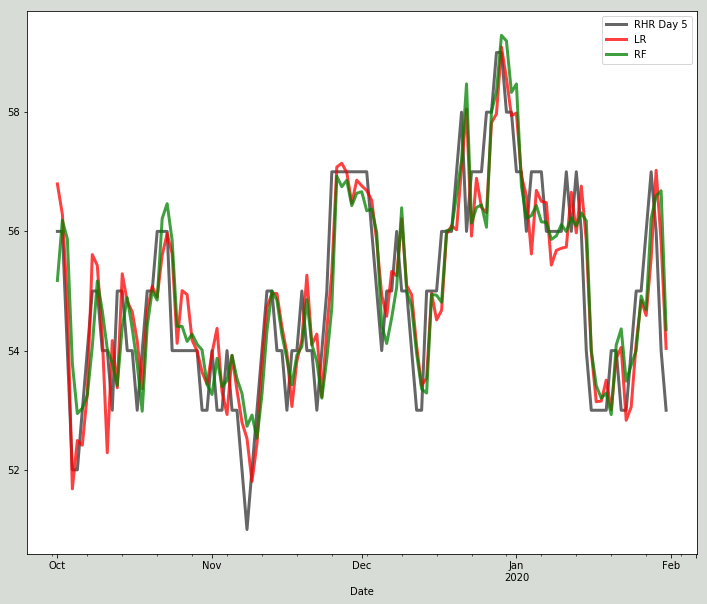

In [0]:
fig = plt.figure(figsize=(12,10), facecolor='#d8dcd6')

actual['RHR Day 5'].plot(legend=True, color='black', lw=3, alpha=.6)
actual['LR'].plot(legend=True, color='red', lw=3, alpha=.75)
actual['RF'].plot(legend=True, color='green', lw=3, alpha=.75)

### Permutation Importance with ELI5

In [0]:
transformers = make_pipeline(
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_test_transformed = transformers.transform(X_test)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='neg_mean_absolute_error', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_test_transformed, y_test)

PermutationImportance(cv='prefit',
           estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
           n_iter=5, random_state=42, refit=True,
           scoring='neg_mean_absolute_error')

In [0]:
feature_names = X_test.columns.tolist()
len(X_test.columns)
#pd.Series(permuter.feature_importances_, feature_names).sort_values()

31

In [0]:
eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
1.1351 ± 0.1661,RHR Day 4
0.0221 ± 0.0172,Activity Calories Day 4
0.0140 ± 0.0189,Minutes REM Sleep
0.0112 ± 0.0203,Minutes Very Active
0.0089 ± 0.0076,Minutes Very Active Day 4
0.0057 ± 0.0052,Minutes Light Sleep
0.0049 ± 0.0051,Minutes Awake
0.0036 ± 0.0100,Minutes Deep Sleep
0.0033 ± 0.0032,Activity Calories Day 3
0.0021 ± 0.0082,RHR Day 3
